In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.interpolate import interp1d
import seaborn as sns
from astropy.cosmology import WMAP9 as cosmo
import pandas as pd
import matplotlib.ticker as ticker
from scipy import constants as sc
from scipy import signal

import numpy as np 
import numpy.linalg as la
import numpy.random as ra
import pandas as pd
import healpy as hp
import astroquery
import scipy.constants as sc
from astroquery.vizier import Vizier



#Packages related to spectra
import window_function_2
import pspec_copy
import make_universe_copy
import cross_pspec

#packages for HERA and 21cm FG simulation
import HERA_hack_FG
import FG_pygsm

#packages for CCAT and [CII] FG simulation
import CII_foregrounds
from CCAT_p import CCAT_p

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize']=11
plt.rcParams['xtick.labelsize']=11



%load_ext autoreload
%autoreload 2

In [3]:
field_21cm = np.loadtxt("21cm_data.txt").reshape(50,50)
field_21cm /= 100
################## TELESCOPE STUFF ##################
dishes = np.array([[0,0],[150,75],[0,150],[0,-57.39295490174667],[30,0],[0,60],[2,55],[47,2],[45,23],[56,21],[30,115],[48,52],[100,100],[0,200],[115,30],[33,31],[49,11],[21,24],[25,6],[56,9],[12,13],[16,17],[38,17],[60,14],[26,28],[6,45],[3,37],[12,55],[200,0],[145,13],[134,65],[139,163]])
data1 = np.loadtxt('/Users/hannahfronenberg/desktop/Grad School/HERA Noise/hera_positions_staged/antenna_positions_37.dat')
hera_bls_core = data1[:,:-1]

data2 = np.loadtxt('/Users/hannahfronenberg/desktop/Grad School/HERA Noise/hera_positions_staged/excess_bls.dat')
hera_bls_outrigger = data2[::5,:-1]

hera_bls = np.vstack((hera_bls_core,hera_bls_outrigger))


npix_row,npix_col = 51,51

Lx = 325
Ly = 325

pbeam = True 
norm = True 

# acorner = np.array([[120,280],[122,282],[120,282],[122,280]])


acorner = np.array([[119,274],[121,276],[119,276],[121,274]])

HERA = HERA_hack_FG.telescope(hera_bls, latitude=-30, channel_width=97800, beam_width=10, beam = 'gaussian')

obs = HERA_hack_FG.observation(telescope = HERA, n_days = 3, freq = 182.54400000000044, delta_t = 0.01 ,corners = acorner, beam_sigma_cutoff=1, sky_shape = (npix_row,npix_col), norm = norm , pbeam = pbeam)

sky = signal.unit_impulse(npix_row*npix_col, 'mid') #delta funtion point source in the middle



In [70]:
HERA.compute_2D_bls()
len_bls = np.sqrt(HERA.bls[:,0]**2 + HERA.bls[:,1]**2)

In [71]:
min(len_bls),max(len_bls)

(0.0, 775.3594349289452)

In [72]:
obs.necessary_times()
A_size = HERA.N_bls*obs.Nt*10000
N_size = HERA.N_bls*obs.Nt*HERA.N_bls*obs.Nt
print(HERA.N_bls)

1321


In [73]:
HERA.N_bls

1321

In [74]:
mem_Amat = (A_size*8)/1e9
mem_N = ((N_size)*8)/1e9

mem_per_cpu = mem_Amat+mem_N
print(mem_per_cpu*48)

5.742735743999999


In [75]:
len(hera_bls_outrigger[:,0])

29

Text(0.5, 1.0, 'My Telescope ')

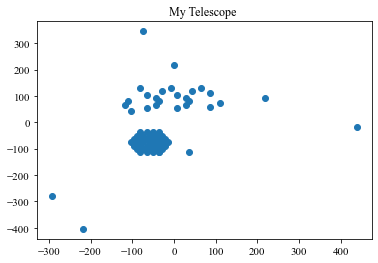

In [76]:
#deparating x and y coordinates for each dish

dishes = hera_bls
x_arr = np.zeros(len(dishes))
y_arr = np.zeros(len(dishes))

for i in range(len(dishes)):
    x_arr[i]= dishes[i,0]
    y_arr[i] = dishes[i,1]


plt.scatter(x_arr,y_arr)

plt.title('My Telescope ')

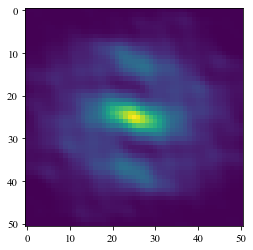

In [77]:
sky_map = np.real(obs.convolve_map(sky,None,None))

plt.imshow(np.real(obs.map).reshape(51,51).T)

In [46]:
obs.map

array([-0.02394674-0.01756992j, -0.02662826-0.02965132j,
       -0.02838749-0.04232299j, ..., -0.02784368+0.03989386j,
       -0.02550789+0.02732039j, -0.02233294+0.01566569j])

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

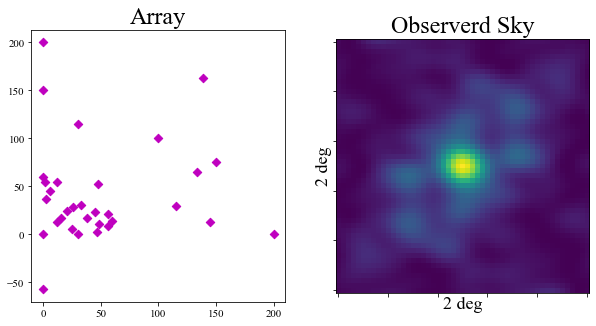

In [107]:

fig3 = plt.figure(figsize = (10,5),constrained_layout=False)
gs = fig3.add_gridspec(1, 2 , width_ratios= [1,1])

ax1 = fig3.add_subplot(gs[0, 0])
ax1.scatter(x_arr,y_arr, marker = 'D', color = 'm')
# ax1.set_xlim(-25,175)
ax1.set_title('Array',fontsize = 24)


ax2 = fig3.add_subplot(gs[0, 1])
im1 = ax2.imshow(sky_map.reshape(51,51).T)
ax2.set_title('Observerd Sky', fontsize = 24)
ax2.set_xlabel('2 deg', fontsize = 18)
ax2.set_ylabel('2 deg', fontsize = 18)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)






In [108]:
HERA.N_bls

494

In [246]:
import numpy as np
from astropy import units as u
beam_sigma = 8.7*u.deg
beam_area = 2*np.pi*(beam_sigma)**2
freq = 140*u.MHz
equiv = u.brightness_temperature(freq)
(8*u.Jy/beam_area).to(u.K, equivalencies=equiv)  

<Quantity 0.09170414 K>

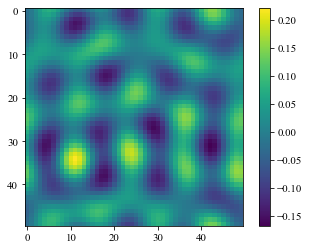

In [218]:
plt.imshow(field_21cm)
plt.colorbar()

# HERA 1 obs No FG

In [219]:
#observe the fake universe
stacked_sky = np.hstack((field_21cm).T)
sky = np.real(obs.convolve_map(stacked_sky,None,None))
square_sky = np.reshape(sky,(npix_row,npix_col)).T


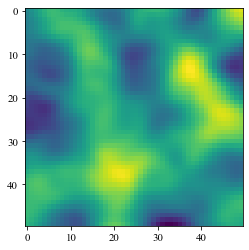

In [247]:

obs.generate_map_noise(None, None)
noise = np.real(np.reshape(obs.noise,(npix_row,npix_col)).T)
# full_sky = square_sky+(noise/300)


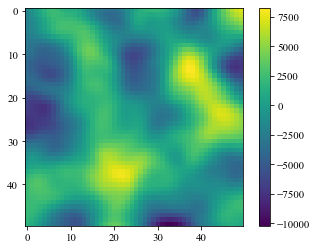

In [248]:
plt.imshow(noise)
plt.colorbar()

In [252]:
obs.my_noise

array([ 0.0547716 +0.19834169j,  0.0315107 -0.10290558j,
        0.02959   -0.02018211j, ...,  0.14982445-0.14857243j,
       -0.00176078+0.06189361j,  0.01667173-0.08849614j])

In [200]:
HERA = open("HERA.txt", "w")

for row in full_sky:
    np.savetxt(HERA, row)

HERA.close()

In [98]:
obs.generate_map_noise(None, None)

array([-17159.78412424+18837.88190848j, -23000.45292036+23530.39948681j,
       -25996.97345913+30243.29780557j, ...,
        46599.49014237-51033.75673583j,  34251.54966576-63704.47508895j,
        21504.36844508-73190.16869896j])

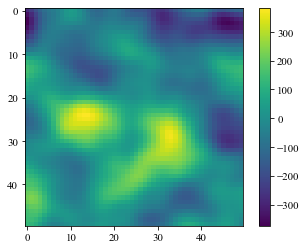

In [209]:
noise = np.real(np.reshape(obs.noise,(npix_row,npix_col)).T)
plt.imshow(noise/300)
plt.colorbar()

In [253]:
#ensemble average Noise error bars.
# same universe, diff noise each time 

nreals = 100
nbins = 30

pspecs_HERA_noFG = []
kmodes = []

sky = np.real(obs.convolve_map(stacked_sky,None,None))
square_sky = np.reshape(sky,(npix_row,npix_col)).T

for i in range(nreals):
    
    obs.generate_map_noise(None, None)
    noise = np.real(np.reshape(obs.noise,(npix_row,npix_col)))
    
    full_map = square_sky + noise/300
     
    power_spec_HERA = pspec_copy.Power_Spectrum(full_map,Ly,Lx,nbins,0.15) #100 Mpc by 100M
    p_21_HERA = power_spec_HERA.compute_2D_pspec()
    pspecs_HERA_noFG.append(p_21_HERA[1])
    
    if i == 0:
        kmodes.append(p_21_HERA[0])
    else:
        pass
    

In [254]:
#COMPUTE AVERAGE AND NOISE ERROR BARS

pspecs_HERA_noFG = np.asarray(pspecs_HERA_noFG)

ave_HERA_spec_noFG = np.sum(pspecs_HERA_noFG,axis = 0)/nreals

sigma_HERA_noFG = []

for i in range(nbins-1):
    k_dist = pspecs_HERA_noFG[:,i]
    sigma_HERA_noFG.append(np.std(k_dist))

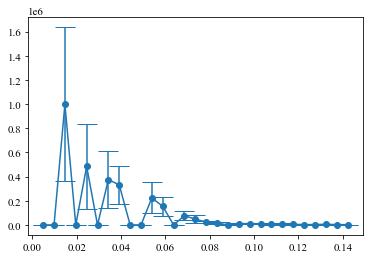

In [255]:
plt.errorbar(kmodes[0],ave_HERA_spec_noFG, xerr = None, yerr = sigma_HERA_noFG, markersize=8, capsize=10)
plt.scatter(kmodes[0],ave_HERA_spec_noFG)

#completely noise dominated! 

In [263]:
data_hera = [ave_HERA_spec_noFG,sigma_HERA_noFG]

HERA_FG = open("data_hera.txt", "w")

for row in data_hera:
    np.savetxt(HERA_FG, row)

HERA_FG.close()

# HERA 1 obs W/ FG

In [225]:
obs.observable_coordinates()
obs.necessary_times()
fg_21cm = FG_pygsm.foregrounds(obs,150)
diffuse_fg = fg_21cm.diffuse_fg(100,True)


In [226]:
diffuse_fg.shape, obs.Npix

((2601,), 2601)

In [53]:
fg_21cm.bright_psources()

OrderedDict([('J/ApJ/684/1143', </>), ('J/ApJ/736/87', </>), ('J/ApJ/738/79', </>), ('J/ApJ/760/12', </>), ('J/ApJ/785/119', </>), ('J/ApJ/813/39', </>), ('J/ApJ/839/12', </>), ('J/ApJ/859/4', </>), ('J/ApJ/879/10', </>), ('J/ApJ/886/75', </>), ('J/ApJ/886/93', </>), ('J/ApJ/887/134', </>), ('J/ApJ/889/L34', </>), ('J/ApJ/892/93', </>), ('J/ApJS/165/360', </>), ('J/ApJS/191/232', </>), ('J/ApJS/236/51', </>), ('J/ApJS/238/29', </>), ('J/A+A/454/717', </>), ('J/A+A/548/A29', </>), ('J/A+A/563/A120', </>), ('J/A+A/578/A51', </>), ('J/A+A/622/A81', </>), ('J/A+A/642/A85', </>), ('J/A+A/647/A78', </>), ('J/A+A/651/A74', </>), ('J/AJ/127/539', </>), ('J/AJ/128/846', </>), ('J/AJ/144/35', </>), ('J/AJ/144/150', </>), ('J/AJ/145/167', </>), ('J/AJ/149/59', </>), ('J/AJ/150/1', </>), ('J/MNRAS/310/982', </>), ('J/MNRAS/359/865', </>), ('J/MNRAS/385/2225', </>), ('J/MNRAS/401/160', </>), ('J/MNRAS/439/611', </>)])
TableList with 70 tables:
	'0:J/ApJ/684/1143/table1' with 15 column(s) and 10224 

AssertionError: 

In [185]:
diffuse_fg_2D = np.reshape(diffuse_fg,(50,50))

FG_21cm = open("FG_21cm.txt", "w")

for row in diffuse_fg_2D:
    np.savetxt(FG_21cm, row)

FG_21cm.close()

In [256]:
#observe the fake universe
stacked_sky = np.hstack((field_21cm).T)
sky = np.real(obs.convolve_map(stacked_sky+diffuse_fg,None,None))
square_sky = np.reshape(sky,(npix_row,npix_col)).T



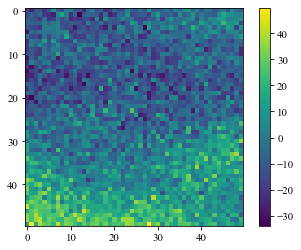

In [245]:
fg_tot_21 = np.reshape(diffuse_fg,(50,50)).T

plt.imshow(fg_tot_21)
plt.colorbar()

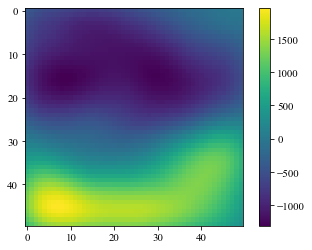

In [239]:
full_sky_FG = square_sky
plt.imshow(full_sky_FG)
plt.colorbar()

In [240]:
HERA_FG = open("HERA_FG.txt", "w")

for row in full_sky_FG:
    np.savetxt(HERA_FG, row)

HERA_FG.close()

In [266]:
#ensemble average Noise error bars.
# same universe, diff noise each time 

nreals = 100
nbins = 30

pspecs_HERA_FG_null = []
kmodes = []

sky = np.real(obs.convolve_map(diffuse_fg,None,None))
square_sky = np.reshape(sky,(npix_row,npix_col)).T

for i in range(nreals):
    
    obs.generate_map_noise(None, None)
    noise = np.real(np.reshape(obs.noise,(npix_row,npix_col)))
    
    full_map = square_sky + noise/300
     
    power_spec_HERA = pspec_copy.Power_Spectrum(full_map,Ly,Lx,nbins,0.15) #100 Mpc by 100M
    p_21_HERA = power_spec_HERA.compute_2D_pspec()
    pspecs_HERA_FG_null.append(p_21_HERA[1])
    
    if i == 0:
        kmodes.append(p_21_HERA[0])
    else:
        pass
    

In [267]:
#COMPUTE AVERAGE AND NOISE ERROR BARS

pspecs_HERA_FG_null = np.asarray(pspecs_HERA_FG_null)

ave_HERA_spec_FG_null  = np.sum(pspecs_HERA_FG_null ,axis = 0)/nreals

sigma_HERA_FG_null  = []

for i in range(nbins-1):
    k_dist = pspecs_HERA_FG_null [:,i]
    sigma_HERA_FG_null .append(np.std(k_dist))

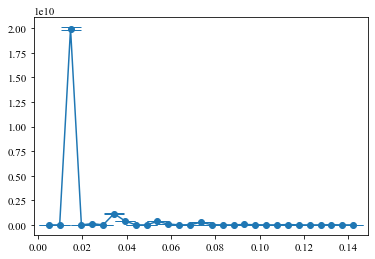

In [269]:
plt.errorbar(kmodes[0],ave_HERA_spec_FG_null , xerr = None, yerr = sigma_HERA_FG_null , markersize=8, capsize=10)
plt.scatter(kmodes[0],ave_HERA_spec_FG_null )

#completely noise dominated! 

In [270]:
data_hera_fg_null = [ave_HERA_spec_FG_null,sigma_HERA_FG_null]

HERA_FG = open("data_hera_fg_null.txt", "w")

for row in data_hera_fg_null:
    np.savetxt(HERA_FG, row)

HERA_FG.close()

# HERA N obs FG


In [260]:
#ensemble average Noise error bars.
# same universe, diff noise each time 

nreals = 10
nbins = 30

pspecs_HERA_NFG = []
kmodes = []

def ps(x):
    mu, sigma = 0.08,0.005
    return  np.exp( - (x - mu)**2 / (2 * sigma**2))

for i in range(nreals):
    make_uni = make_universe_copy.universe(ps,npix_row,npix_col,Ly,Lx, mean = None) #100 Mpc by 100Mpc
    field_21cm = make_uni.make_2D_universe()
    
    stacked_sky = np.hstack((field_21cm).T)
    sky = np.real(obs.convolve_map(stacked_sky+diffuse_fg,None,None))
    square_sky = np.reshape(sky,(npix_row,npix_col)).T
    
    obs.generate_map_noise(None, None)
    noise = np.real(np.reshape(obs.noise,(npix_row,npix_col)))
    
    full_map = square_sky + noise/300
     
    power_spec_HERA = pspec_copy.Power_Spectrum(full_map,Ly,Lx,nbins,0.15) #100 Mpc by 100M
    p_21_HERA = power_spec_HERA.compute_2D_pspec()
    pspecs_HERA_NFG.append(p_21_HERA[1])
    
    if i == 0:
        kmodes.append(p_21_HERA[0])
    else:
        pass

In [261]:
#COMPUTE AVERAGE AND NOISE ERROR BARS

pspecs_HERA_NFG = np.asarray(pspecs_HERA_NFG)

ave_HERA_spec_NFG = np.sum(pspecs_HERA_FG,axis = 0)/nreals

sigma_HERA_NFG = []

for i in range(nbins-1):
    k_dist = pspecs_HERA_FG[:,i]
    sigma_HERA_NFG.append(np.std(k_dist))

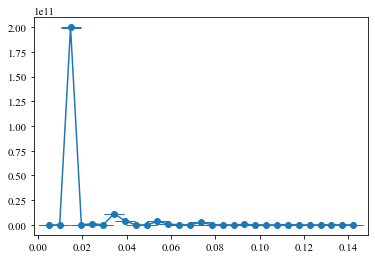

In [262]:
plt.errorbar(kmodes[0],ave_HERA_spec_NFG, xerr = None, yerr = sigma_HERA_NFG, markersize=8, capsize=10)
plt.scatter(kmodes[0],ave_HERA_spec_NFG)

#completely noise dominated! 

In [265]:
data_hera_fg_Nobs = [ave_HERA_spec_NFG,sigma_HERA_NFG]

HERA_NFG = open("data_hera_fg_Nobs.txt", "w")

for row in data_hera_fg_Nobs:
    np.savetxt(HERA_NFG, row)

HERA_NFG.close()